# CS345 Climate Control Analysis

This is a script to plot graphs relating to the climate control sensor network. The following graphs are produced.

1. A graph of temperature of the room (Y-axis) vs time (X-axis).
1. The average number of messages sent each time a sensor sends a message to the sink (Y: avg number, X: time).
1. The average number of messages when a sink sends a message to the actuators (Y: avg number, X: time).
1. The average energy consumption over the duration of the experiment (Y: energy usage, X: time).
1. A “heatmap” showing the energy consumption for nodes in the network.

All import libraries used in this application are listed as following.

In [1]:
#system built-in
import os
import sys
import time
import math

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

Analysis will be made based on the log output from various motes, import all logs.

In [2]:
LOG_DIR = "../run/"
#mote id for log
SINK_LOG = 1
CLIMATE_SENSOR_LOG = range(2, 6)
ACTUATOR_LOG = range(6, 8)
#and all the rests are relays

#simulation comnfigurations
MOTE_COUNT = 15
TICK_PER_SECOND = 1000000
SIMULATION_TIME = 16200 #in second
BAR_WIDTH_FACTOR = 180 #the ratio of bar width to simulation time in a bar chart
CHART_COLOR = "#24e3ba"
HEATMAP_CUTOFF = 2.5 #basically controls the size of circles

BAR_WIDTH = SIMULATION_TIME / BAR_WIDTH_FACTOR

def getLogFilename(mote_id):
    return LOG_DIR + "mote_" + str(mote_id) + ".log"

Define utilities to analyse log files from, and extract output based on the requirements:

- Sink
- Climate sensor
- Actuator
- Relay

In [3]:
def analyseResult(log_filename, strategy):
    result = list()
    
    #read the log file
    with open(log_filename, "r") as log:
        #parse every line
        for line in log:
            #remove leading and trailing space
            line = line.strip()
            #split every word as an array
            field = line.split()
            
            #call the analysis method
            if not strategy(line, field, result):
                #signal to stop parsing
                break
    return result

#900654632 [INFO: Sink      ]
#Received all temperature from 4 climate sensors, mean temperature is 21.824570
def analyseTemperature(sink_line, sink_field, avgTempData):
    if "Received all temperature" in sink_line:
        #time is the first element
        time = int(sink_field[0]) / TICK_PER_SECOND
        #temperature is the last word in the line
        avgTemp = float(sink_field[-1])
        #record
        avgTempData.append((time, avgTemp))
        
    return True

#1800272000 [INFO: ClimateSensor] Sending sensor reading '22.212212' to fd00::201:1:1:1
def analyseSensorSink(sensor_line, sensor_field, avgTxData):
    if "Sending sensor reading" in sensor_line:
        time = int(sensor_field[0]) / TICK_PER_SECOND
        #round time to nearest 100
        time = round(time / 100) * 100
        avgTxData.append((time, 1))
        
    return True

#1500662632 [INFO: Sink      ] Status update sent to 2 AC units.
def analyseSinkActuator(sink_line, sink_field, avgTxData):
    if "sent to 2 AC units" in sink_line:
        time = int(sink_field[0]) / TICK_PER_SECOND
        avgTxData.append((time, 1))
    
    return True
        
#1800780000 [INFO: Link Stats] num packets: tx=4 ack=4 rx=3 queue_drops=0 to=0001.0001.0001.0001
def analyseEnergy(mote_id, energy_line, energy_field, avgEnergyData):
    if "Link Stats] num packets:" in energy_line:
        time = int(energy_field[0]) / TICK_PER_SECOND
        time = round(time / 100) * 100
        #analysis link stats
        tx = int(energy_field[6].split("=")[1])
        ack = int(energy_field[7].split("=")[1])
        rx = int(energy_field[8].split("=")[1])
        
        avgEnergyData.append((mote_id, time, tx + ack + rx))
        
    return True

#572000 [Simulation Script] Mote global position: (-49.609701148830354, 54.52929393806501, 0)
def getMotePosition(heat_line, heat_field, heatData):
    if "[Simulation Script] Mote global position" in heat_line:
        #parse position
        x = float(heat_field[6][1:-1])#remove left round bracket and ending comma
        y = float(heat_field[7][:-1])#remove ending comma
        #don't worry about z, it's a 2D map anyway
        heatData.append((x, y))
        
        #we only need the position, stop parsing
        return False
    
    return True

Run the application to retrieve all required data.

In [4]:
#room temperature
roomTemp = pd.DataFrame(columns = ["time", "temperature"], 
                        data = analyseResult(getLogFilename(SINK_LOG), analyseTemperature))

#message from sensor to sink
sensor_sinkMsg = list()
for sensor in CLIMATE_SENSOR_LOG:
    sensor_sinkMsg += analyseResult(getLogFilename(sensor), analyseSensorSink)
sensor_sinkMsg = pd.DataFrame(columns = ["time", "message_count"], data = sensor_sinkMsg)

#message from sink to actuator
sink_actuatorMsg = pd.DataFrame(columns = ["time", "message_count"], 
                                data = analyseResult(getLogFilename(SINK_LOG), analyseSinkActuator))

#average energy consumption of the whole network
#for generating heatmap, acquire position of all motes
energyCons = list()
motePos = list()
for mote in range(MOTE_COUNT):
    #as a reminder mote ID starts from 1
    filename = getLogFilename(mote + 1)
    energyCons += analyseResult(filename, 
                           lambda line, field, data : analyseEnergy(mote, line, field, data))
    motePos += analyseResult(filename, getMotePosition)
energyCons = pd.DataFrame(columns = ["mote_id", "time", "energy_metrics"], data = energyCons)
motePos = pd.DataFrame(columns = ["X", "Y"], data = motePos)

Plot graphs using obtained data.

In [5]:
#a helper function for returning a common plot style
def setupGraph(xLabel, yLabel, title):
    graph = plt.figure(figsize = [8, 8])
    axis = graph.add_subplot(1, 1, 1)
    #plot
    axis.set_title(title, fontsize = 14)
    axis.set_xlabel(xLabel, fontsize = 12)
    axis.set_ylabel(yLabel, fontsize = 12)
    
    axis.set_xlim(left = 0, right = SIMULATION_TIME)
    
    return axis

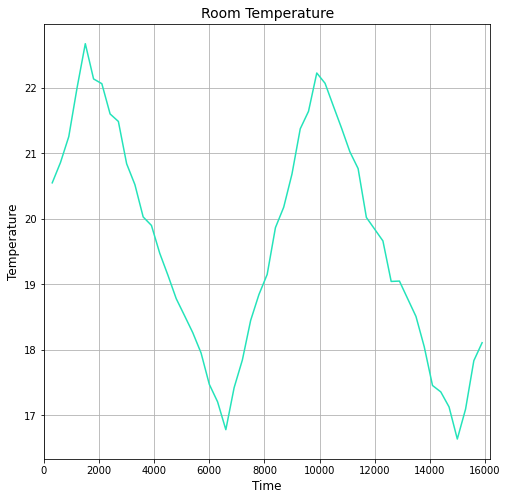

In [6]:
#plot time against room temp
tempAx = setupGraph("Time", "Temperature", "Room Temperature")
tempAx.plot(roomTemp["time"], roomTemp["temperature"], color = CHART_COLOR)
tempAx.grid()

<BarContainer object of 53 artists>

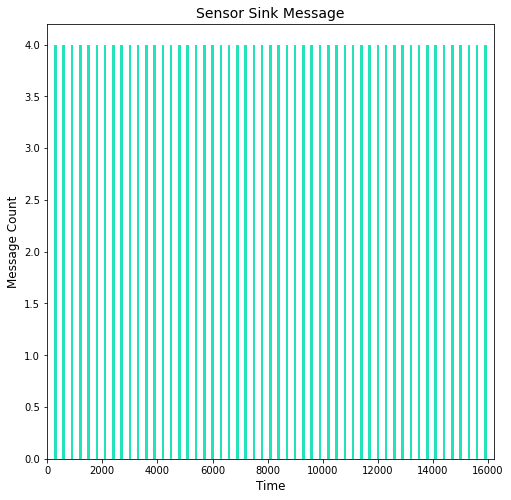

In [7]:
#plot time against message sent from sensor to sink
sensor_sinkGroup = sensor_sinkMsg.groupby("time").sum()

sensor_sinkAx = setupGraph("Time", "Message Count", "Sensor Sink Message")
sensor_sinkAx.bar(sensor_sinkGroup.index, sensor_sinkGroup["message_count"], 
                  width = BAR_WIDTH, color = CHART_COLOR)

<BarContainer object of 4 artists>

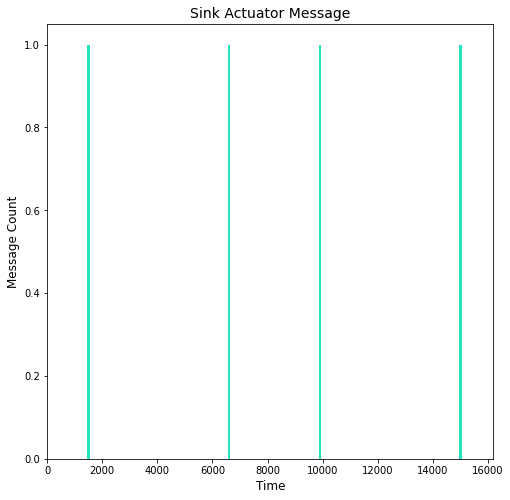

In [8]:
#plot time against message sent from sink to actuator
sink_actuatorAx = setupGraph("Time", "Message Count", "Sink Actuator Message")
sink_actuatorAx.bar(sink_actuatorMsg["time"], sink_actuatorMsg["message_count"], 
                    width = BAR_WIDTH, color = CHART_COLOR)

<BarContainer object of 17 artists>

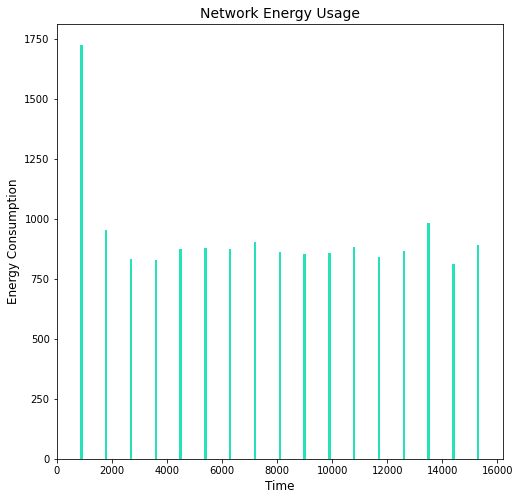

In [9]:
#plot time against average energy consumption of the network
energyGroup = energyCons.groupby(by = "time").sum().drop(labels = "mote_id", axis = "columns")

energyAx = setupGraph("Time", "Energy Consumption", "Network Energy Usage")
energyAx.bar(energyGroup.index, energyGroup["energy_metrics"], 
             width = BAR_WIDTH, color = CHART_COLOR)

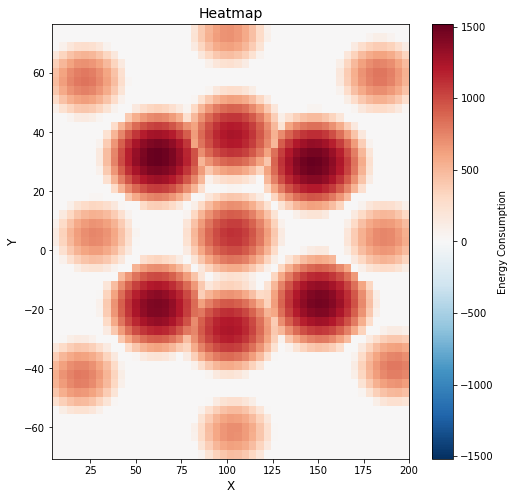

In [10]:
#plot heatmap
moteEnergyGroup = energyCons.groupby(by = "mote_id").sum().drop(labels = "time", axis = "columns")
maxEnergy = moteEnergyGroup.max()
heatmapAx = setupGraph("X", "Y", "Heatmap")
heatmapAx.axis("auto")

#this controls the size of our heatmap
minPos = motePos.min() - 10
maxPos = motePos.max() + 10
#in order to make the heatmap smooth, generate a detailed grid
LoD = 50
gridY, gridX = np.meshgrid(
    np.linspace(minPos["X"], maxPos["X"], LoD), np.linspace(minPos["Y"], maxPos["Y"], LoD))
heat = np.zeros(shape = (LoD, LoD))

spaceY, spaceX = np.abs(maxPos["Y"] - minPos["Y"]) / LoD, np.abs(maxPos["X"] - minPos["X"]) / LoD
#calculate distance to closest point
for x, y in np.ndindex(heat.shape):
    #calculate current coordinate
    position = [minPos["X"] + x * spaceX, minPos["Y"] + y * spaceY]
    #nearest point
    dist = np.sum((position - motePos)**2, axis = 1)
    #asthe pixel getting further, energy decreases
    deltaHeat = moteEnergyGroup["energy_metrics"][np.argmin(dist)] - dist.min() * HEATMAP_CUTOFF
    heat[x][y] = np.clip(deltaHeat, 0.0, maxEnergy)
    
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
heat = heat[:-1, :-1]
heat_min, heat_max = -np.abs(heat).max(), np.abs(heat).max()

heatmap = heatmapAx.pcolormesh(gridX, gridY, heat, 
                               cmap = "RdBu_r", vmin = heat_min, vmax = heat_max)
plt.gcf().colorbar(heatmap, ax = heatmapAx, label = "Energy Consumption")